# PW5 — Wellenoptik 

---

## Allgemeine Grundlagen

### Lehr- und Lernziele
- Arbeiten mit den Welleneigenschaften des Lichts  
- Interferenz- und Beugungsprozesse verstehen  
- Interferenzbedingungen verstehen  
- Übergang von Einzelspalt zu Doppelspalt und Beugungsgitter nachvollziehen  

**Begriffe:**  
Wellenoptik, Interferenz, Kohärenz, Huygens-Fresnel’sches Prinzip, Fraunhofer’sche und Fresnel’sche Beugungserscheinungen, Laser

---

### Licht als Welle – Interferenz

Licht kann als elektromagnetische Welle beschrieben werden. Darauf weisen Interferenz- und Beugungsphänomene hin.  
Die Vektoren der elektrischen und magnetischen Feldstärke stehen senkrecht aufeinander und auf die Ausbreitungsrichtung.

$$
E(x, t) = E_0 e^{i\omega (t - x/c)}
$$

Nur der **Realteil** dieser Gleichung ist physikalisch bedeutungsvoll.  
Dabei gilt:
- $ E_0 = |E_0| $: Amplitude  
- $ \omega = 2\pi f $: Kreisfrequenz  
- $ c $: Ausbreitungsgeschwindigkeit  

Zusammenhang zwischen Frequenz und Wellenlänge:

$$
c = \lambda f
$$

Die beobachtbare **Intensität** ist proportional zum zeitlichen Mittelwert des Betragsquadrats der Feldstärke:

$$
I \propto \langle |E(x, t)|^2 \rangle = \langle E(x,t)E^*(x,t)\rangle
$$

Überlagern sich zwei Wellen, ergibt sich:

$$
E_1(x,t) = E_{01} e^{i\omega(t-x/c)} \quad \text{und} \quad E_2(x,t) = E_{02} e^{i(\omega(t-x/c)+\delta)}
$$

mit Phasenverschiebung  
$$
\delta = \frac{2\pi \Delta x}{\lambda}
$$

Gesamtfeld:

$$
E(x,t) = (E_{01} + E_{02} e^{i\delta}) e^{i\omega(t-x/c)}
$$

Intensität:

$$
I \propto (E_{01} + E_{02} e^{i\delta})(E_{01} + E_{02} e^{-i\delta}) = E_{01}^2 + E_{02}^2 + 2E_{01}E_{02}\cos\delta
$$

Mit $ I_1 = E_{01}^2 $ und $ I_2 = E_{02}^2 $:

$$
I = I_1 + I_2 + 2\sqrt{I_1 I_2}\cos\delta
$$

**Konstruktive Interferenz:** $ \delta = 2k\pi \Rightarrow \Delta x = k\lambda $  
**Destruktive Interferenz:** $ \delta = (2k + 1)\pi \Rightarrow \Delta x = k\lambda + \frac{\lambda}{2} $

---

### Kohärenz

Interferenz ist nur möglich, wenn die überlagerten Wellen kohärent sind.  
Licht besteht aus **zeitlich und räumlich begrenzten Wellengruppen**, deren Länge $ l $ die **Kohärenzlänge** und deren Dauer $ \tau $ die **Kohärenzdauer** genannt wird.

Bedingungen für beobachtbare Interferenz:

- Die **Wegdifferenz** der interferierenden Wellen muss kleiner als die Kohärenzlänge sein.  
- Die **Phasendifferenz** darf sich während der Beobachtungszeit nicht wesentlich ändern.  

Für ausgedehnte Lichtquellen gilt zusätzlich:

$$
\sin u \leq \frac{\lambda}{2y}
$$

wobei $ u $ der Öffnungswinkel und $ y $ die Ausdehnung der Quelle ist.

---

### Laser

In normalen Lichtquellen dominiert **spontane Emission** – jedes Atom sendet unabhängig Licht aus.  
Beim **Laser** (Light Amplification by Stimulated Emission of Radiation) überwiegt die **induzierte Emission**.

Ein **aktives Medium** (z. B. He-Ne-Gas, Rubin, Halbleiter) wird durch äußere Anregung in einen Zustand der **Besetzungsinversion** gebracht.  
Zwischen zwei Spiegeln entsteht ein optischer Resonator, der kohärentes, monochromatisches Licht mit großer Kohärenzlänge liefert.

Eigenschaften von Laserlicht:
- hohe räumliche und zeitliche Kohärenz  
- hohe spektrale Energiedichte  
- große Amplitudenstabilität  
- geringe Divergenz  

---

### Fraunhofer- und Fresnelbeugung

Trifft Licht auf ein Hindernis (z. B. Spalt, Draht), wird es **gebeugt**.  
Nach dem **Huygensschen Prinzip** wirkt jeder Punkt einer Wellenfront als Ausgangspunkt einer Elementarwelle.

Für eine Öffnung der Breite $ a $ gilt:

$$
R \gg \frac{a^2}{\lambda}
$$

Dann spricht man von **Fraunhofer- (Fernfeld-)Beugung**.  
Wird diese Bedingung nicht erfüllt, beobachtet man **Fresnel- (Nahfeld-)Beugung**.

- **Fraunhoferbeugung:** klare, stationäre Interferenzstreifen, die sich mit zunehmendem Abstand besser trennen.  
- **Fresnelbeugung:** komplexe Muster, die sich mit dem Abstand verändern (z. B. Talbot-Abbildungen).

---


## Auswertung – Beugung am Einzelspalt
Für die Beugungsminima eines Einzelspalts gilt die Beziehung:

$$
a \sin \alpha_n = n \lambda
$$

mit  
- $a$: Spaltbreite  
- $\alpha_n$: Ablenkwinkel des n-ten Minimums  
- $\lambda$: Wellenlänge des verwendeten Lichts  
- $n = 1, 2, 3, ...$: Ordnungszahl des Minimums  

Da die Winkel klein sind ($<5°$), gilt näherungsweise:

$$
\sin \alpha_n \approx \tan \alpha_n = \frac{y_n}{L}
$$

Hierbei ist  
- $y_n$: Abstand des n-ten Minimums vom Zentralmaximum auf dem Schirm  
- $L$: Abstand zwischen Spalt und Schirm  

Daraus folgt:

$$
a = \frac{n \lambda L}{y_n}
$$

Zur genaueren Bestimmung von $a$ wird ein Diagramm erstellt, in dem  
auf der Ordinate $n\lambda$ und auf der Abszisse $\alpha_n$ (in Radiant) aufgetragen wird.  
Die Punkte sollten annähernd auf einer Geraden liegen, deren **Steigung die Spaltbreite $a$** darstellt.  
Durch lineare Regression erhält man den exakten Wert von $a$ einschließlich Unsicherheit.

---

Linearer Fit: alpha = s*n + c (gewichtete Ausgleichsgerade)
  s = 0.01599 +/- 0.00002 rad/Ordnung
  R^2 = 1.0000

Spaltbreite:
  b = 39.71 +/- 0.04 um


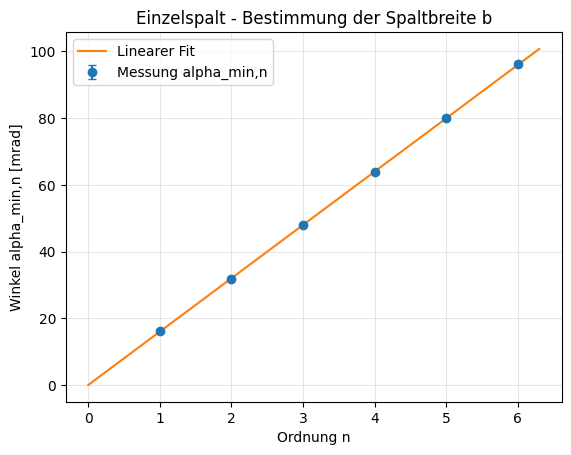

In [21]:
# --- Importe ---
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# --- Hilfsfunktion: schoene Ausgabe im Format "x +/- dx" ---
def pm(val, err):
    if err == 0 or not np.isfinite(err):
        return f"{val:g}"
    k = int(np.floor(np.log10(abs(err))))  # Stelle der ersten signifikanten Ziffer
    r = round(err, -k)                     # Fehler auf eine signifikante Ziffer runden
    fmt = f"{{:.{-k}f}} +/- {{:.{-k}f}}" if k < 0 else "{:.0f} +/- {:.0f}"
    return fmt.format(val, r)

# --- Parameter (anpassen) ---
lambda_nm = 635.0
sigma_lambda_nm = 0.0       # 0 falls vernachlaessigt
L = 1.500                   # m
sigma_L = 0.001

# --- Messdaten (Beispiel): Abstand (-n) bis (+n) in mm ---
data_paare = pd.DataFrame({
    "n": [1, 2, 3, 4, 5, 6],
    "y_minus_mm": [-48.5, -96.0, -144.5, -192.0, -240.0, -289.5],  
    "y_plus_mm":  [ 48.0,  95.0,  144.0,  191.0,  240.5,  289.0]
})

df = data_paare.copy()
# Halber Abstand vom Zentrum: Mittelwert der Abweichungen links/rechts
df["y_half_mm"] = (df["y_plus_mm"] - df["y_minus_mm"]) / 2.0
D_mm = df["y_half_mm"].to_numpy()
n = df["n"].to_numpy().astype(float)
sigma_D_mm = np.full_like(D_mm, 1.0)

# --- Von D zu Winkeln ---
y = (D_mm * 1e-3) / 2.0
sigma_y = (sigma_D_mm * 1e-3) / 2.0
alpha = np.arctan2(y, L)
fac = 1.0 / (1.0 + (y / L) ** 2)
sigma_alpha = np.sqrt((fac * (1 / L) * sigma_y) ** 2 + (fac * (-y / L ** 2) * sigma_L) ** 2)

# --- Gewichteter linearer Fit: alpha = s*n + c (kein polyfit) ---
x, yv, w = n, alpha, 1.0 / (sigma_alpha ** 2)
enforce_through_origin = True  # True: Fit durch den Ursprung erzwingen

if enforce_through_origin:
    Sxx = np.sum(w * x * x)
    Sxy = np.sum(w * x * yv)
    slope = Sxy / Sxx
    intercept = 0.0
    yhat = slope * x
    res = yv - yhat
    dof = len(x) - 1
    sigma2_hat = np.sum(w * res ** 2) / dof
    cov_s = sigma2_hat / Sxx
    slope_stderr = np.sqrt(cov_s)
    intercept_stderr = np.nan
else:
    Sw, Sx, Sy = np.sum(w), np.sum(w * x), np.sum(w * yv)
    Sxx, Sxy = np.sum(w * x * x), np.sum(w * x * yv)
    Delta = Sw * Sxx - Sx ** 2
    slope = (Sw * Sxy - Sx * Sy) / Delta
    intercept = (Sxx * Sy - Sx * Sxy) / Delta
    yhat = slope * x + intercept
    res = yv - yhat
    dof = len(x) - 2
    sigma2_hat = np.sum(w * res ** 2) / dof
    cov = sigma2_hat * np.array([[Sxx, -Sx], [-Sx, Sw]]) / Delta
    intercept_stderr = np.sqrt(cov[0, 0])
    slope_stderr = np.sqrt(cov[1, 1])

# --- Gewichtetes Bestimmtheitsmass R^2 ---
ybar_w = np.sum(w * yv) / np.sum(w)
SS_res_w = np.sum(w * (res ** 2))
SS_tot_w = np.sum(w * ((yv - ybar_w) ** 2))
R2 = 1.0 - SS_res_w / SS_tot_w

# --- Berechnung der Spaltbreite b ---
b = lambda_nm * 1e-9 / slope
db = np.sqrt((sigma_lambda_nm * 1e-9 / slope) ** 2 +
             (-(lambda_nm * 1e-9 / slope ** 2) * slope_stderr) ** 2)

# --- Ausgabe der Ergebnisse ---
print("Linearer Fit: alpha = s*n + c (gewichtete Ausgleichsgerade)")
print(f"  s = {pm(slope, slope_stderr)} rad/Ordnung")
if not enforce_through_origin:
    print(f"  c = {pm(intercept, intercept_stderr)} rad")
print(f"  R^2 = {R2:.4f}")
print("\nSpaltbreite:")
print(f"  b = {pm(b * 1e6, db * 1e6)} um")

# --- Darstellung ---
plt.figure()
plt.errorbar(x, yv * 1000, yerr=1000 / np.sqrt(w), fmt='o', capsize=3,
             label="Messung alpha_min,n")
xx = np.linspace(0, 1.05 * np.max(x), 200)
yy = slope * xx + (0 if enforce_through_origin else intercept)
plt.plot(xx, yy * 1000, label="Linearer Fit")
plt.xlabel("Ordnung n")
plt.ylabel("Winkel alpha_min,n [mrad]")
plt.title("Einzelspalt - Bestimmung der Spaltbreite b")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


## Auswertung – Beugung und Interferenz am Doppelspalt

Die Intensitätsverteilung lautet:

$$
I(\alpha) = 4 I_0 \cos^2\!\left(\frac{\pi b \sin\alpha}{\lambda}\right)
\left(\frac{\sin(\pi a \sin\alpha / \lambda)}{\pi a \sin\alpha / \lambda}\right)^2
$$

- $ a$: Spaltbreite (Breite jedes einzelnen Spalts)  
- $ b$: Spaltabstand (Abstand der Spaltmitten)  
- $ \lambda$: Wellenlänge des verwendeten Lichts  
- $ \alpha$: Beugungswinkel

Die **cos²-Funktion** beschreibt das Interferenzmuster (enge Maxima und Minima),  
die **sin²/β²-Funktion** die Beugungshüllkurve.

### Bedingungen für Maxima und Minima

- **Interferenzmaxima** (helle Streifen):
  $$
  b \sin\alpha_{\text{max},k} = k\lambda \quad (k = 0,1,2,\dots)
  $$

- **Interferenzminima** (dunkle Streifen):
  $$
  b \sin\alpha_{\text{min},k} = \left(k+\frac{1}{2}\right)\lambda
  $$

- **Beugungsminima** (Hüllkurven-Minima):
  $$
  a \sin\alpha_{\text{min},n} = n\lambda
  $$

Das gesamte Muster kann daher als Produkt aus der **Einzelspalt-Beugung** und der **Doppelspalt-Interferenz** verstanden werden.

### Bestimmung der Parameter
1. **Bestimmung der Hüllkurve (a):**  
   Aus den Minima der äußeren Beugungshüllkurve (wie beim Einzelspalt).

2. **Bestimmung der Interferenzstreifen (b):**  
   Messung der Winkel der feinen Minima (dunklen Linien) zwischen den Maxima,  
   anschließend lineare Auswertung mit
   $$
   \sin\alpha_k = m(2k+1), \quad m = \frac{\lambda}{2b}.
   $$
   Daraus folgt:
   $$
   b = \frac{\lambda}{2m}.
   $$



=== Doppelspalt: Bestimmung der Spaltbreite b ===
Steigung s = 0.007784 +/- 0.000010 rad/Ordnung
R^2 = 1.0000
Spaltbreite b = 81.58 +/- 0.10 um



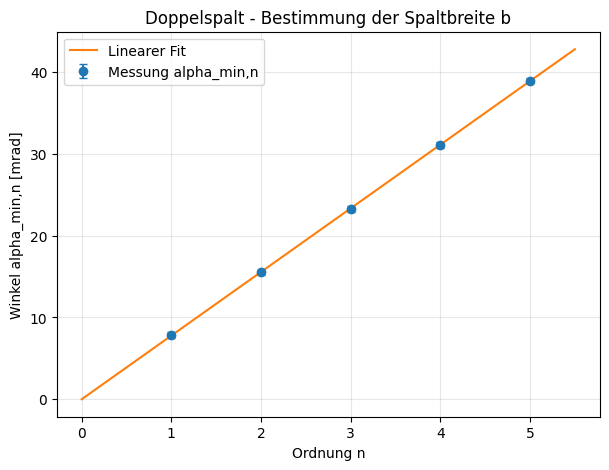

=== Doppelspalt: Bestimmung des Spaltabstands g ===
Steigung s = 0.01363 +/- 0.00001 rad/Ordnung
R^2 = 1.0000
Spaltabstand g = 46.60 +/- 0.04 um



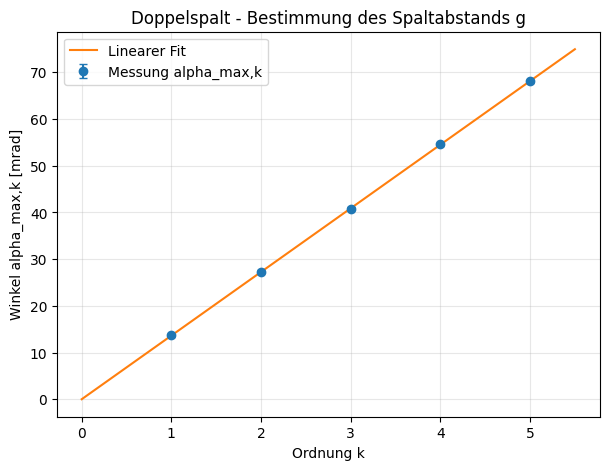

In [22]:
# --- Importe ---
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# --- Hilfsfunktion fuer die Ausgabe im Format "x +/- dx" ---
def pm(val, err):
    if err == 0 or not np.isfinite(err):
        return f"{val:g}"
    k = int(np.floor(np.log10(abs(err))))
    r = round(err, -k)
    fmt = f"{{:.{-k}f}} +/- {{:.{-k}f}}" if k < 0 else "{:.0f} +/- {:.0f}"
    return fmt.format(val, r)

# --- Parameter ---
lambda_nm = 635.0     # nm
sigma_lambda_nm = 0.0
L = 1.500             # m
sigma_L = 0.001       # m

# ================================================================
#   TEIL 1: Doppelspalt – Bestimmung der Spaltbreite b
# ================================================================
# Minima 1. Ordnung: aus der Einzelspalt-Huellkurve im Doppelspaltmuster
data_minima = pd.DataFrame({
    "n": [1, 2, 3, 4, 5],
    "y_minus_mm": [-11.8, -23.3, -35.0, -46.8, -58.6],
    "y_plus_mm":  [ 11.8,  23.3,  34.8,  46.6,  58.4]
})
sigma_y_mm = 0.5
df_b = data_minima.copy()
df_b["y_half_mm"] = (df_b["y_plus_mm"] - df_b["y_minus_mm"]) / 2.0
df_b["sigma_y_half_mm"] = sigma_y_mm

n = df_b["n"].to_numpy(dtype=float)
y_b_m = df_b["y_half_mm"].to_numpy(dtype=float) * 1e-3
sigma_y_b_m = df_b["sigma_y_half_mm"].to_numpy(dtype=float) * 1e-3

# --- Umrechnung in den Winkel alpha ---
alpha_b = np.arctan2(y_b_m, L)
fac_b = 1.0 / (1.0 + (y_b_m / L) ** 2)
sigma_alpha_b = np.sqrt((fac_b * (1 / L) * sigma_y_b_m) ** 2 +
                        (fac_b * (-y_b_m / L ** 2) * sigma_L) ** 2)

# --- Lineare Regression: alpha = s * n ---
x, yv, w = n, alpha_b, 1.0 / (sigma_alpha_b ** 2)
Sxx = np.sum(w * x * x)
Sxy = np.sum(w * x * yv)
slope_b = Sxy / Sxx
res = yv - slope_b * x
dof = len(x) - 1
sigma2_hat = np.sum(w * res ** 2) / dof
slope_b_err = np.sqrt(sigma2_hat / Sxx)

# --- Bestimmung des Bestimmtheitsmasses R^2 ---
ybar_w = np.sum(w * yv) / np.sum(w)
R2_b = 1.0 - np.sum(w * (res ** 2)) / np.sum(w * ((yv - ybar_w) ** 2))

# --- Berechnung der Spaltbreite b ---
b = lambda_nm * 1e-9 / slope_b
db = np.sqrt((sigma_lambda_nm * 1e-9 / slope_b) ** 2 +
             ((-lambda_nm * 1e-9 / slope_b ** 2) * slope_b_err) ** 2)

# --- Ausgabe der Ergebnisse ---
print("=== Doppelspalt: Bestimmung der Spaltbreite b ===")
print(f"Steigung s = {pm(slope_b, slope_b_err)} rad/Ordnung")
print(f"R^2 = {R2_b:.4f}")
print(f"Spaltbreite b = {pm(b * 1e6, db * 1e6)} um\n")

# --- Darstellung der Messwerte und des Fits ---
plt.figure(figsize=(7, 5))
plt.errorbar(x, yv * 1e3, yerr=sigma_alpha_b * 1e3, fmt='o', capsize=3,
             label="Messung alpha_min,n")
xx = np.linspace(0, np.max(x) * 1.1, 200)
plt.plot(xx, slope_b * xx * 1e3, label="Linearer Fit")
plt.xlabel("Ordnung n")
plt.ylabel("Winkel alpha_min,n [mrad]")
plt.title("Doppelspalt - Bestimmung der Spaltbreite b")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# ================================================================
#   TEIL 2: Doppelspalt – Bestimmung des Spaltabstands g
# ================================================================
# Maxima 2. Ordnung: symmetrische k-te Maxima links und rechts
data_maxima = pd.DataFrame({
    "k": [1, 2, 3, 4, 5],
    "y_minus_mm": [-20.5, -41.0, -61.5, -82.0, -102.5],
    "y_plus_mm":  [ 20.5,  41.0,  61.0,  82.0,  102.0]
})

df_g = data_maxima.copy()
df_g["y_half_mm"] = (df_g["y_plus_mm"] - df_g["y_minus_mm"]) / 2.0
sigma_y_mm = 0.5
df_g["sigma_y_half_mm"] = sigma_y_mm

k = df_g["k"].to_numpy(dtype=float)
y_half_m = df_g["y_half_mm"].to_numpy(dtype=float) * 1e-3
sigma_y_half_m = df_g["sigma_y_half_mm"].to_numpy(dtype=float) * 1e-3

# --- Umrechnung in den Winkel alpha ---
alpha = np.arctan2(y_half_m, L)
fac = 1.0 / (1.0 + (y_half_m / L) ** 2)
sigma_alpha = np.sqrt((fac * (1 / L) * sigma_y_half_m) ** 2 +
                      (fac * (-y_half_m / L ** 2) * sigma_L) ** 2)

# --- Lineare Regression: alpha = s * k ---
x, yv, w = k, alpha, 1.0 / (sigma_alpha ** 2)
Sxx = np.sum(w * x * x)
Sxy = np.sum(w * x * yv)
slope_g = Sxy / Sxx
res = yv - slope_g * x
dof = len(x) - 1
sigma2_hat = np.sum(w * res ** 2) / dof
slope_g_err = np.sqrt(sigma2_hat / Sxx)

# --- Bestimmung des Bestimmtheitsmasses R^2 ---
ybar_w = np.sum(w * yv) / np.sum(w)
R2_g = 1.0 - np.sum(w * (res ** 2)) / np.sum(w * ((yv - ybar_w) ** 2))

# --- Berechnung des Spaltabstands g ---
g = lambda_nm * 1e-9 / slope_g
dg = np.sqrt((sigma_lambda_nm * 1e-9 / slope_g) ** 2 +
             ((-lambda_nm * 1e-9 / slope_g ** 2) * slope_g_err) ** 2)

# --- Ausgabe der Ergebnisse ---
print("=== Doppelspalt: Bestimmung des Spaltabstands g ===")
print(f"Steigung s = {pm(slope_g, slope_g_err)} rad/Ordnung")
print(f"R^2 = {R2_g:.4f}")
print(f"Spaltabstand g = {pm(g * 1e6, dg * 1e6)} um\n")

# --- Darstellung der Messwerte und des Fits ---
plt.figure(figsize=(7, 5))
plt.errorbar(x, yv * 1e3, yerr=sigma_alpha * 1e3, fmt='o', capsize=3,
             label="Messung alpha_max,k")
xx = np.linspace(0, np.max(x) * 1.1, 200)
plt.plot(xx, slope_g * xx * 1e3, label="Linearer Fit")
plt.xlabel("Ordnung k")
plt.ylabel("Winkel alpha_max,k [mrad]")
plt.title("Doppelspalt - Bestimmung des Spaltabstands g")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


## Grundlagen – Wellenlängenmessung mit dem Beugungsgitter

Ein **Beugungsgitter** besteht aus einer großen Anzahl paralleler, äquidistanter Spalte mit dem Abstand $ g $ (Gitterkonstante).  
Wenn kohärentes Licht oder das Licht einer Spektrallampe auf das Gitter fällt, wird es an jedem Spalt gebeugt.  
Die gebeugten Wellen **interferieren miteinander**, wodurch ein charakteristisches Spektrum aus hellen Linien entsteht.

### Prinzip

Jeder Spalt wirkt wie eine Quelle für Elementarwellen.  
Im Fernfeld (Fraunhofer-Bedingung) überlagern sich diese Wellen.  
Je nach Gangunterschied $ \Delta x = g \sin\alpha $ kommt es zu Verstärkung oder Auslöschung.

Damit ergibt sich die **Gittergleichung**:

$$
g \sin\alpha_k = k \lambda \quad (k = 0, 1, 2, \dots)
$$

- $ g $: Abstand zwischen zwei benachbarten Spalten (Gitterkonstante)  
- $ \alpha_k $: Beugungswinkel der $k$-ten Ordnung  
- $ \lambda $: Wellenlänge des Lichts  
- $ k $: Beugungsordnung (0 = Hauptmaximum, 1 = erste Ordnung usw.)

Nur unter den Winkeln, bei denen die Phasenunterschiede Vielfache von $2\pi$ sind,  
treten **helle Interferenzmaxima** auf.

### Intensitätsverteilung

Die allgemeine Intensität hinter einem Gitter mit $N$ Spalten ergibt sich aus:

$$
I(\alpha) = I_0
\left( \frac{\sin(\delta^*/2)}{\delta^*/2} \right)^2
\left( \frac{\sin(N\delta/2)}{\sin(\delta/2)} \right)^2,
$$

wobei
$$
\delta = \frac{2\pi g \sin\alpha}{\lambda}, \quad
\delta^* = \frac{2\pi a \sin\alpha}{\lambda}.
$$

- Der erste Faktor beschreibt die **Einzelspalt-Beugung** (Hüllkurve).  
- Der zweite Faktor beschreibt die **Interferenz von N Spalten** – die Gitterfunktion.

Mit wachsender Spaltzahl $N$ werden die Maxima **sehr scharf** und liegen **weit voneinander getrennt**.  
Dadurch kann man unterschiedliche Wellenlängen desselben Lichts klar voneinander unterscheiden – das ist die Grundlage der **Spektroskopie**.

### Physikalische Bedeutung

Das Beugungsgitter dient als **optischer Analysator** zur Trennung des Lichts nach seiner Wellenlänge.  
Jede Wellenlänge erfüllt ihre eigene Beugungsbedingung $ g \sin\alpha = k\lambda $  
und erscheint daher unter einem bestimmten Winkel $ \alpha $.

Je größer $ g $ (bzw. je feiner das Gitter, desto kleiner $ g $),  
desto stärker werden die Spektrallinien voneinander getrennt.

### Experimentelles Vorgehen

1. Eine Spektrallampe beleuchtet den Spalt eines Kollimators → paralleles Lichtbündel.  
2. Das Licht trifft **senkrecht auf das Transmissionsgitter**.  
3. Hinter dem Gitter erscheint ein **Spektrum** mit Maxima 1., 2., 3. Ordnung auf beiden Seiten.  
4. Mit einem Goniometer oder Fernrohr werden die Winkel $ \alpha_k $ der einzelnen Linien gemessen.  
   Um die Genauigkeit zu erhöhen, wird der Winkel zwischen den symmetrischen Linien links und rechts gemessen und halbiert.

### Auswertung

Aus der Gittergleichung:
$$
\lambda = \frac{g \sin\alpha_k}{k}.
$$

- $g$ ist bekannt (auf dem Gitter angegeben oder vom Betreuer angegeben).  
- $k$ ist die Ordnung der beobachteten Linie.  
- $ \alpha_k $ wird aus den Messungen bestimmt.  

Für jede beobachtete Linie erhält man also den Wert von $ \lambda $.  
Durch Vergleich mit Tabellenwerten kann man identifizieren, **welches Gas** in der Spektrallampe verwendet wurde (z. B. Natrium, Wasserstoff, Quecksilber).



In [23]:
# --- Wellenlaengenmessung mit dem Gitter ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Hilfsfunktion fuer die Ausgabe im Format "x +/- dx" ---
def pm(val, err):
    if err == 0 or not np.isfinite(err):
        return f"{val:g}"
    k = int(np.floor(np.log10(abs(err))))
    r = round(err, -k)
    fmt = f"{{:.{-k}f}} +/- {{:.{-k}f}}" if k < 0 else "{:.0f} +/- {:.0f}"
    return fmt.format(val, r)

# ============== 1. Bestimmung der Gitterkonstante g ==================
# Bekannte Wellenlaenge des Lasers (z.B. He-Ne-Laser)
lambda_laser_nm = 635.0
sigma_lambda_laser_nm = 0.5
lambda_laser_m = lambda_laser_nm * 1e-9

# Messwerte fuer die Beugung des Lasers (k = 1)
alpha_right = 20
alpha_left = -20
alpha_deg = (alpha_right - alpha_left) / 2          # gemessener Beugungswinkel
sigma_alpha_deg = 0.2
k = 1

# Umrechnung von Grad in Radiant
alpha_rad = np.deg2rad(alpha_deg)
sigma_alpha_rad = np.deg2rad(sigma_alpha_deg)

# Berechnung der Gitterkonstante: g = k * lambda / sin(alpha)
g_m = k * lambda_laser_m / np.sin(alpha_rad)

# Fehlerfortpflanzung fuer g
sigma_g_m = g_m * np.sqrt(
    (sigma_lambda_laser_nm / lambda_laser_nm) ** 2 +
    (np.cos(alpha_rad) / np.sin(alpha_rad) * sigma_alpha_rad) ** 2
)

# Ausgabe der berechneten Gitterkonstante
print("=== Gitterkonstante aus Laser-Messung ===")
print(f"g = {pm(g_m * 1e6, sigma_g_m * 1e6)} um")

# ============== 2. Bestimmung der Wellenlaengen aus der Spektrallampe =====
# Beispielhafte Messdaten der Spektrallampe
data = pd.DataFrame({
    "name": ["gelb", "gelb", "gruen", "gruen", "blau"],
    "k": [1, 2, 1, 2, 1],
    "alpha_links": [-18.90, -39.10, -20.15, -41.95, -14.10],
    "alpha_rechts": [18.95, 39.05, 20.20, 42.05, 14.05],
    "sigma_alpha_deg": [0.2, 0.2, 0.2, 0.2, 0.2]
})

# Berechnung der mittleren Beugungswinkel aus den Messwerten
data["alpha_deg"] = (data["alpha_rechts"] - data["alpha_links"]) / 2
data["alpha_rad"] = np.deg2rad(data["alpha_deg"])
data["sigma_alpha_rad"] = np.deg2rad(data["sigma_alpha_deg"])

# Berechnung der Wellenlaengen: lambda = g * sin(alpha) / k
data["lambda_m"] = g_m * np.sin(data["alpha_rad"]) / data["k"]
data["sigma_lambda_m"] = np.sqrt(
    (np.sin(data["alpha_rad"]) / data["k"] * sigma_g_m) ** 2 +
    (g_m * np.cos(data["alpha_rad"]) / data["k"] * data["sigma_alpha_rad"]) ** 2
)

# Umrechnung der Wellenlaengen in Nanometer
data["lambda_nm"] = data["lambda_m"] * 1e9
data["sigma_lambda_nm"] = data["sigma_lambda_m"] * 1e9

# Ausgabe der berechneten Wellenlaengen
print("\n=== Wellenlaengen der Spektrallinien ===")
for _, row in data.iterrows():
    print(f"{row['name']:>5s}: lambda = {pm(row['lambda_nm'], row['sigma_lambda_nm'])} nm")

# ============== 3. Plot der Ergebnisse ===============================
# Die folgenden Zeilen koennen aktiviert werden, um die Messwerte grafisch darzustellen.
# plt.figure(figsize=(7, 4))
# plt.errorbar(
#     data["alpha_deg"], data["lambda_nm"],
#     yerr=data["sigma_lambda_nm"], xerr=data["sigma_alpha_deg"],
#     fmt="o", capsize=4, label="Spektrallinien"
# )
# plt.title("Wellenlaengen aus Beugungswinkeln (Gitter bestimmt aus Laser)")
# plt.xlabel("Beugungswinkel alpha (Grad)")
# plt.ylabel("Wellenlaenge lambda (nm)")
# plt.grid(True)
# plt.legend()
# plt.show()


=== Gitterkonstante aus Laser-Messung ===
g = 1.86 +/- 0.02 um

=== Wellenlaengen der Spektrallinien ===
 gelb: lambda = 602 +/- 8 nm
 gelb: lambda = 585 +/- 6 nm
gruen: lambda = 640 +/- 9 nm
gruen: lambda = 621 +/- 6 nm
 blau: lambda = 452 +/- 8 nm


![](spektrallinien.png)

Unser Meinung nach, muss es <> sein